## Load Double Pendulum Trajectories

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

# Restrict TensorFlow to only use the first GPU
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

4 Physical GPUs, 1 Logical GPU


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from utils import DoublePendulum, calc_double_E

L1, L2 = 1, 1
M1, M2 = 1, 1
theta1, omega1 = np.random.uniform(-3*np.pi/7, 3*np.pi/7), 0
theta2, omega2 = np.random.uniform(-3*np.pi/4, 3*np.pi/4), 0

dp = DoublePendulum(L1, L2, M1, M2, theta1, omega1, theta2, omega2)
t, y = dp.generate(tmax=300, dt=0.0001)

params = {'M1': dp.M1, 'M2': dp.M2, 'L1': dp.L1, 'L2': dp.L2, 'g': dp.g}
V, T, E = calc_double_E(y, **params)

Length (L1,L2) and Mass (M1,M2) of a string: (1,1) (1,1)
Initial theta(degree): 0.783368(44.883704),0.757937(43.426595)
Initial omega: 0.000000,0.000000


Text(0, 0.5, 'Velocity (rad/s)')

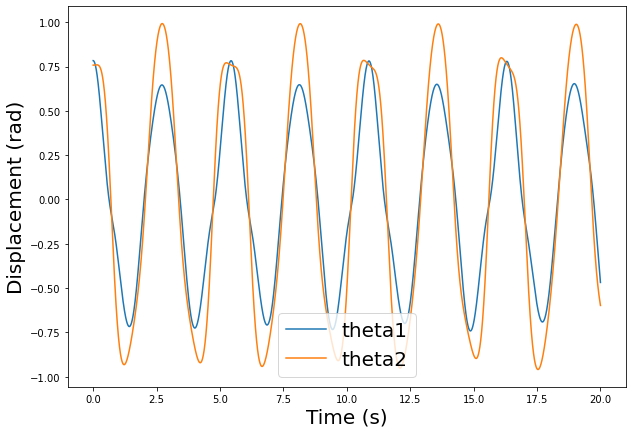

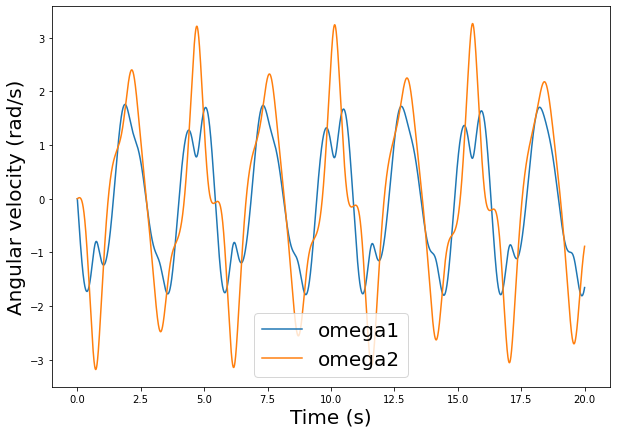

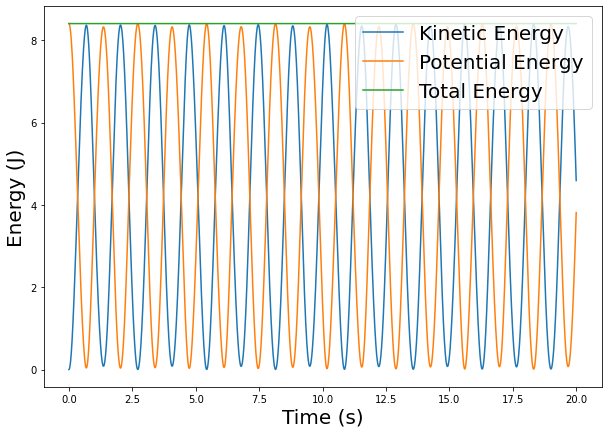

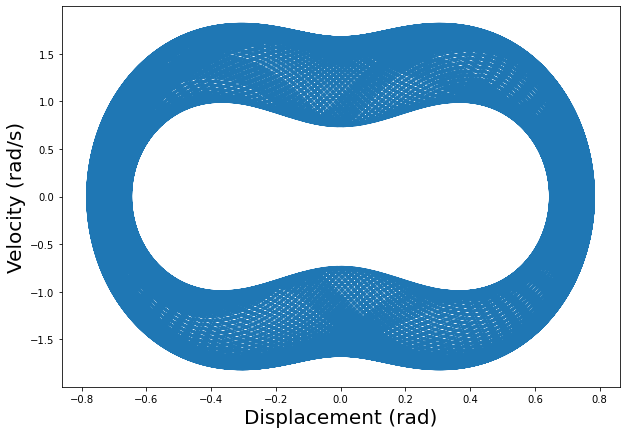

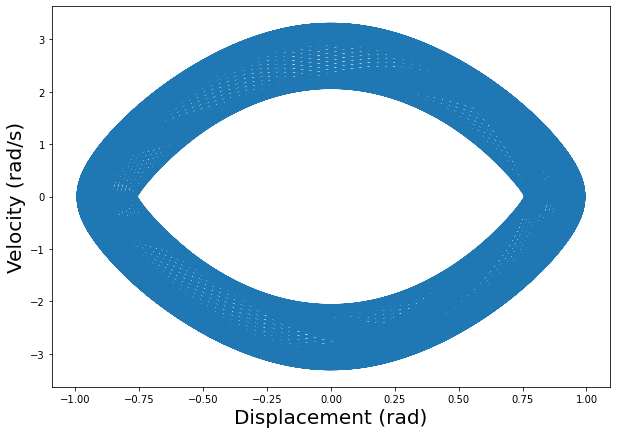

In [3]:
'''Plotting'''
# Unpack z and theta as a function of time
theta1, theta2 = y[:,0], y[:,2]
omega1, omega2 = y[:,1], y[:,3]

plt.figure(0, figsize=(10,7))
plt.plot(t[:200000], theta1[:200000], label='theta1')
plt.plot(t[:200000], theta2[:200000], label='theta2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Displacement (rad)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(t[:200000], omega1[:200000], label='omega1')
plt.plot(t[:200000], omega2[:200000], label='omega2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Angular velocity (rad/s)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(2, figsize=(10,7))
plt.plot(t[:200000], T[:200000], label='Kinetic Energy')
plt.plot(t[:200000], V[:200000], label='Potential Energy')
plt.plot(t[:200000], E[:200000], label='Total Energy')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Energy (J)', fontsize=20)

plt.figure(3, figsize=(10,7))
plt.plot(theta1, omega1)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

plt.figure(4, figsize=(10,7))
plt.plot(theta2, omega2)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

In [4]:
'''
Data preprocessing for NN
'''
import tensorflow as tf

device = '/GPU'

sampling_step = 100    # sample a row for every the step.
sampling_ind = np.arange(0, t.shape[0]-1, sampling_step)
scaler = 1.0
scaled_y = np.array(y)
# scaled_y[:,1] = scaled_y[:,1]*scaler

state_dim = y.shape[1]
input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
input_output_y = input_output_y.astype(np.float32)
input_states = input_output_y[sampling_ind, :state_dim]    # input state
output_states = input_output_y[sampling_ind, state_dim:]    # next state

num_samples = input_states.shape[0]
train_x, train_y = input_states[:int(num_samples*0.6)], output_states[:int(num_samples*0.6)]
valid_x, valid_y = input_states[int(num_samples*0.6):int(num_samples*0.7)], output_states[int(num_samples*0.6):int(num_samples*0.7)]
test_x, test_y = input_states[int(num_samples*0.7):], output_states[int(num_samples*0.7):]

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y), )
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

print("data size: {}/{}/{}".format(len(train_x), len(valid_x), len(test_x)))

train_dataset = train_dataset.shuffle(1000).batch(32)
valid_dataset = valid_dataset.batch(valid_x.shape[0])
test_dataset = test_dataset.batch(test_x.shape[0])

data size: 18000/3000/9000


In [ ]:
'''
toy model
'''
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=[state_dim]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4),
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mae',
              metrics=['mae'])

model.summary()

model.fit(train_dataset, epochs=50)

In [ ]:
output = model.predict(test_x)

plt.figure(0, figsize=(10,7))
plt.plot(test_y[:500, 0], '.-', label='gt theta1')
plt.plot(output[:500, 0], '.-', label='pred theta1')
plt.plot(test_y[:500, 1], '.-', label='gt omega1')
plt.plot(output[:500, 1], '.-', label='pred omega1')

In [41]:
'''
Proposed controllable architecture
'''

from tensorflow.keras import layers


class Net(tf.keras.Model):
    def __init__(self, input_dim, output_dim, hidden_dim=16):
        super(Net, self).__init__()

        self.rule_encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu', input_shape=(input_dim,)),
            layers.Dense(hidden_dim, activation='tanh')
        ])

        self.data_encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu', input_shape=(input_dim,)),
            layers.Dense(hidden_dim, activation='tanh')
        ])
    
        self.net = tf.keras.Sequential([
            layers.Dense(32, activation='relu', input_shape=(hidden_dim*2,)),
            layers.Dense(output_dim)
        ])

    def call(self, x, alpha=0.0):
        rule_z = self.rule_encoder(x)
        data_z = self.data_encoder(x)
        
        z = layers.Concatenate(axis=-1)([alpha*rule_z, (1-alpha)*data_z])    # merge: Concat

        return self.net(z)

    
def compute_loss(model, x, y, physics=False, dp=None):
    
    if physics:
        alpha = tf.random.uniform([1])    # alpha
        y_pred = model(x, alpha)
        loss_state = tf.reduce_mean(tf.keras.losses.MAE(y, y_pred))
    
        from utils import calc_double_E
        dp_params = {'M1': dp.M1, 'M2': dp.M2, 'L1': dp.L1, 'L2': dp.L2, 'g': dp.g}
        _, _, curr_E = calc_double_E(x, **dp_params)
        _, _, next_E = calc_double_E(y_pred, **dp_params)
        loss_cons = tf.reduce_mean(tf.nn.relu(next_E - curr_E))

        return alpha*loss_cons + (1-alpha)*loss_state    # energy conservation + state prediction
    else:
        y_pred = model(x, 0.0)
        loss_state = tf.reduce_mean(tf.keras.losses.MAE(y, y_pred))
    
        return loss_state


@tf.function
def train_step(model, x, y, optimizer, physics=False, dp=None):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y, physics=physics, dp=dp)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


input_dim = 4
hidden_dim = 16
output_dim = 4

lr = 0.001
optimizer = tf.keras.optimizers.Adam(lr)

model = Net(input_dim, output_dim)

w_before = model.rule_encoder.layers[0].weights[0][:2].numpy()

In [42]:
epochs = 50
for epoch in range(1, epochs + 1):
    for tr_x, tr_y in train_dataset:
        train_step(model, tr_x, tr_y, optimizer, physics=True, dp=dp)
#         train_step(model, tr_x, tr_y, optimizer, physics=False)
    
    train_loss = tf.reduce_mean(tf.keras.losses.MAE(train_y, model(train_x)))
    valid_loss = tf.reduce_mean(tf.keras.losses.MAE(valid_y, model(valid_x)))
    
    print('Epoch: {}, Train MAE: {:.6f},\t Valid MAE: {:.6f}'.format(epoch, train_loss, valid_loss))
    
w_after = model.rule_encoder.layers[0].weights[0][:2].numpy()

np.allclose(w_before, w_after)

Epoch: 1, Train MAE: 0.056628,	 Valid MAE: 0.058380
Epoch: 2, Train MAE: 0.041162,	 Valid MAE: 0.043863
Epoch: 3, Train MAE: 0.039332,	 Valid MAE: 0.041653
Epoch: 4, Train MAE: 0.026999,	 Valid MAE: 0.029101
Epoch: 5, Train MAE: 0.035829,	 Valid MAE: 0.036491
Epoch: 6, Train MAE: 0.021717,	 Valid MAE: 0.022656
Epoch: 7, Train MAE: 0.025816,	 Valid MAE: 0.025988
Epoch: 8, Train MAE: 0.017902,	 Valid MAE: 0.019232
Epoch: 9, Train MAE: 0.022967,	 Valid MAE: 0.023718
Epoch: 10, Train MAE: 0.051164,	 Valid MAE: 0.050624
Epoch: 11, Train MAE: 0.017806,	 Valid MAE: 0.018108
Epoch: 12, Train MAE: 0.036648,	 Valid MAE: 0.035808
Epoch: 13, Train MAE: 0.027041,	 Valid MAE: 0.028266
Epoch: 14, Train MAE: 0.024413,	 Valid MAE: 0.024529
Epoch: 15, Train MAE: 0.019931,	 Valid MAE: 0.019734
Epoch: 16, Train MAE: 0.024504,	 Valid MAE: 0.024261
Epoch: 17, Train MAE: 0.020945,	 Valid MAE: 0.020364
Epoch: 18, Train MAE: 0.023629,	 Valid MAE: 0.022932
Epoch: 19, Train MAE: 0.019039,	 Valid MAE: 0.019402
Ep

False

In [ ]:
output = model.predict(test_x)

plt.figure(0, figsize=(10,7))
plt.plot(test_y[:1000, 0], '.-', label='gt theta1')
plt.plot(output[:1000, 0], '.-', label='pred theta1')
plt.plot(test_y[:1000, 1], '.-', label='gt omega1')
plt.plot(output[:1000, 1], '.-', label='pred omega1')

In [44]:
# model_hybrid = model
# model_data = model

# model = model_hybrid
# model = model_data

input_data = test_x
target_data = test_y

y_pred = model(input_data, alpha=0.0)

test_mae_loss = tf.reduce_mean(tf.keras.losses.MAE(target_data, y_pred))

test_mae_loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.021062622>

In [ ]:
0.0051373043    # data only
0.021062622    # hybrid

Test set: Average loss: 0.02106262 (alpha:0.0)
ratio of verified predictions: 0.848778 (alpha:0.0)
Test set: Average loss: 0.02034993 (alpha:0.1)
ratio of verified predictions: 0.842778 (alpha:0.1)
Test set: Average loss: 0.01994243 (alpha:0.2)
ratio of verified predictions: 0.840000 (alpha:0.2)
Test set: Average loss: 0.01978707 (alpha:0.3)
ratio of verified predictions: 0.840000 (alpha:0.3)
Test set: Average loss: 0.01986531 (alpha:0.4)
ratio of verified predictions: 0.843778 (alpha:0.4)
Test set: Average loss: 0.02013725 (alpha:0.5)
ratio of verified predictions: 0.848556 (alpha:0.5)
Test set: Average loss: 0.02064218 (alpha:0.6)
ratio of verified predictions: 0.874778 (alpha:0.6)
Test set: Average loss: 0.02139196 (alpha:0.7)
ratio of verified predictions: 0.912444 (alpha:0.7)
Test set: Average loss: 0.02244388 (alpha:0.8)
ratio of verified predictions: 0.946111 (alpha:0.8)
Test set: Average loss: 0.02415414 (alpha:0.9)
ratio of verified predictions: 0.965667 (alpha:0.9)
Test set: 

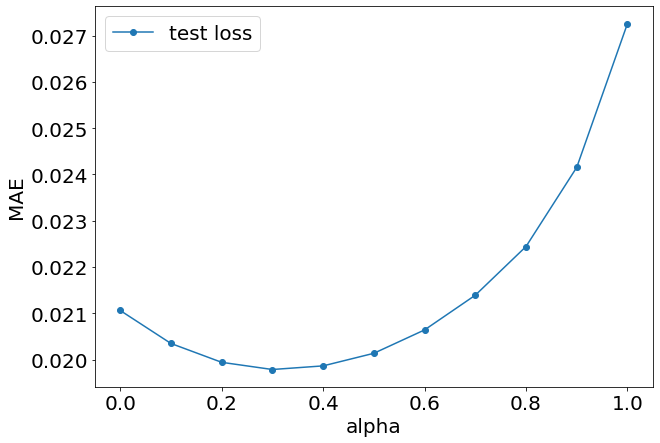

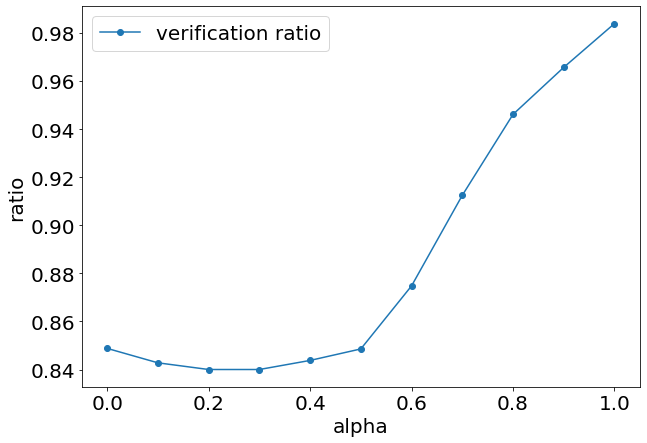

In [47]:
from utils import verification

model = model_hybrid
# model = model_data

test_loss_alpha = []
test_ratio_alpha = []
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for _alpha in alphas:

    input_data = test_x
    target_data = test_y
        
    y_pred = model(input_data, alpha=_alpha)
        
    test_mae_loss = tf.reduce_mean(tf.keras.losses.MAE(target_data, y_pred))
        
    _, _, curr_E = calc_double_E(input_data, **params)
    _, _, next_E = calc_double_E(target_data, **params)
    _, _, pred_E = calc_double_E(y_pred, **params)

    test_ratio = verification(curr_E, pred_E, threshold=0.0)

    print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_mae_loss, _alpha))
    print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, _alpha))
    
    test_loss_alpha.append(test_mae_loss)
    test_ratio_alpha.append(test_ratio)

    
    
plt.figure(0, figsize=(10,7))
plt.plot(alphas, test_loss_alpha, 'o-', label='test loss')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(alphas, test_ratio_alpha, 'o-', label='verification ratio')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)